*Before we get started, please note that I put in magic pip install lines to install everything this code needs to run locally, please check your kernal before running against the next code block. Especially notice shap which lets me explore the feature importance of our model later.*

In [ ]:
%pip install pandas
%pip install matplotlib
%pip install sklearn
%pip install seaborn
%pip install numpy
%pip install shap

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (train_test_split, GridSearchCV, HalvingGridSearchCV, RepeatedStratifiedKFold)
from sklearn.tree import plot_tree
from sklearn import metrics
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.metrics import roc_curve
import shap


# Predicting Churn from Iranian Telecom Customer Data
*Data graciously hosted by UC Irvine at DOI:[10.24432/C5JW3Z](https://doi.org/10.24432/C5JW3Z)*

This project is all about constructing an effective binary classification model to predict customer churn from a variety of data randomly collected by an Iranian telecom company. By the end of this writeup we'll have a very effective model for predicting customer churn, explored the feature importance of that model, and proposed next steps. In the bonus section we'll also use probability tuning to turn our binary prediction into a probabilistic one without hurting the f1 score.

Table of contents
1. [Introduction to the dataset](#1)
2. [Exploratory data analysis](#2)
3. Naive model training for benchmarking
4. Hyperparameter searching
5. Choosing a model
6. Final model performance and feature importance
7. Conclusions, suggested next steps
8. BONUS: Turning our model output into a probability of churn

## Introduction to the dataset <a class="anchor" name="1"></a>
The dataset comes clean, with no missing values for 3150 customers. It has 9 months of data for the features. The label, churn, is evaluated at the 12 month mark. It has the following columns, sorted by type.

- Features
    - Binary
        - Complains (0: did not complain during the time period, 1: did complain during the time period)
        - Tariff Plan (1: Pay as you go, 2: Contractual)
        - Status (1: active, 2: non-active, what this means is not stated)
    - Ordinal
        - Charge Amount (0: lowest amount, 9: highest amount)
        - Age Group (1: youngest age group, 5: oldest age group)
    - Continuous
        - Call  Failure (int, number of call failures)
        - Seconds of Use (int, total seconds of calls)
        - Frequency of use (int, total number of calls)
        - Frequency of SMS (int, total number of text messages)
        - Distinct Called Numbers (int, total number of distinct phone calls)
        - Customer Value (float, the value of the customer, method and denomination not stated)
        - Age (int, seems to be the center of the age group bin the customer is in)
        - Subscription  Length (int, likely taken at the end of the 9 month period)
- Labels
    - Churn (binary, int, 0: did not churn between 9 and 12 months, 1: did churn between 9 and 12 months)

I will use all features except age and status. I neglect age because it is functionally a repetition of age group and neglet status because I'm not able to find out the meaning of it and want to avoid data leakage.

In [76]:
df.keys()

Index(['Call  Failure', 'Complains', 'Subscription  Length', 'Charge  Amount',
       'Seconds of Use', 'Frequency of use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Tariff Plan', 'Status', 'Age',
       'Customer Value', 'Churn'],
      dtype='object')

In [91]:
df = pd.read_csv("data/Customer Churn.csv", delimiter=",")
cont_keys = ['Call  Failure', 'Seconds of Use' , 'Frequency of use', 'Frequency of SMS', 'Distinct Called Numbers', 'Customer Value', 'Subscription  Length']
ordinal_keys = ['Age Group', 'Charge  Amount']
binary_keys = ['Tariff Plan', 'Complains']

predictor_keys = [x for x in df.keys() if not (x  in ['Churn', 'Status', 'Age'])]
label_key = ['Churn']
df.head()


,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


## Exploratory Data Analysis <a class="anchor" name="2"></a>

First let's check for any missing data

In [71]:
df.isnull().sum()

Call  Failure              0
Complains                  0
Subscription  Length       0
Charge  Amount             0
Seconds of Use             0
Frequency of use           0
Frequency of SMS           0
Distinct Called Numbers    0
Age Group                  0
Tariff Plan                0
Status                     0
Age                        0
Customer Value             0
Churn                      0
dtype: int64

No missing data we have to deal with. Let's look at our label distribution

In [73]:
df.Churn.value_counts(normalize = True)

Churn
0    0.842857
1    0.157143
Name: proportion, dtype: float64

Again, 1 is that the customer churned between 9 and 12 months and 0 is they did not. The majority of customers didn't churn which is great! The label classes are imbalanced. Instead of resampling we'll keep it in mind and change the class weights down the line so we can use the whole data set.

Let's take a look at the histograms of all our continuous variables

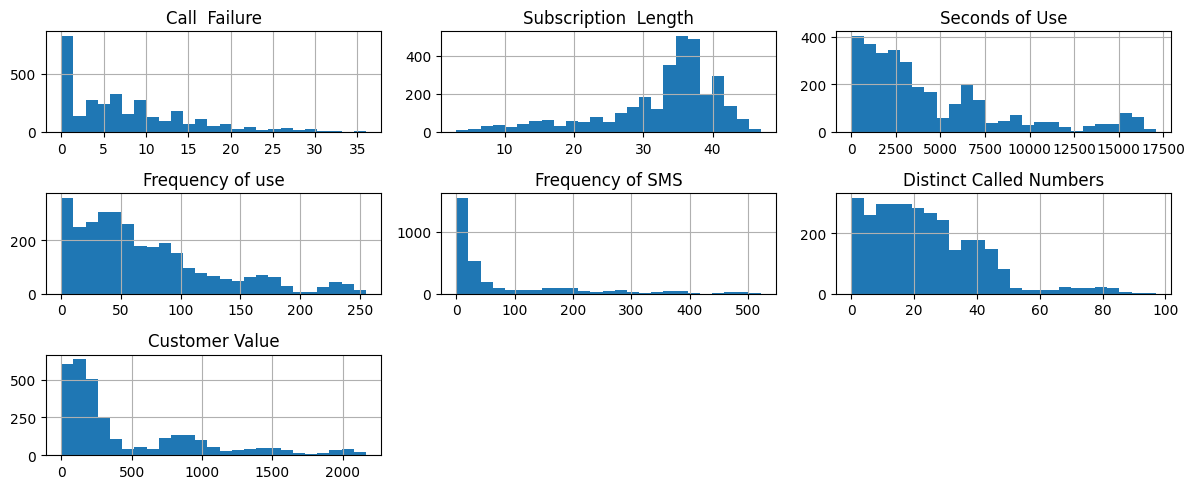

In [96]:
df[[x for x in df.keys() if x in cont_keys]].hist(bins=25, figsize= (12,5))
plt.tight_layout()

Every continuous variable is non-normal here. Even subscription length, which is the closest to normal, has a giant left sided tail. I notice an interesting wavy pattern in frequency of use, frequency of sms, and customer value where there seems to be some kind of attenuating bouncing. Could be worth future investigation but shouldn't effect our prediction.

Let's see what the histograms for the ordinal and binary values look like

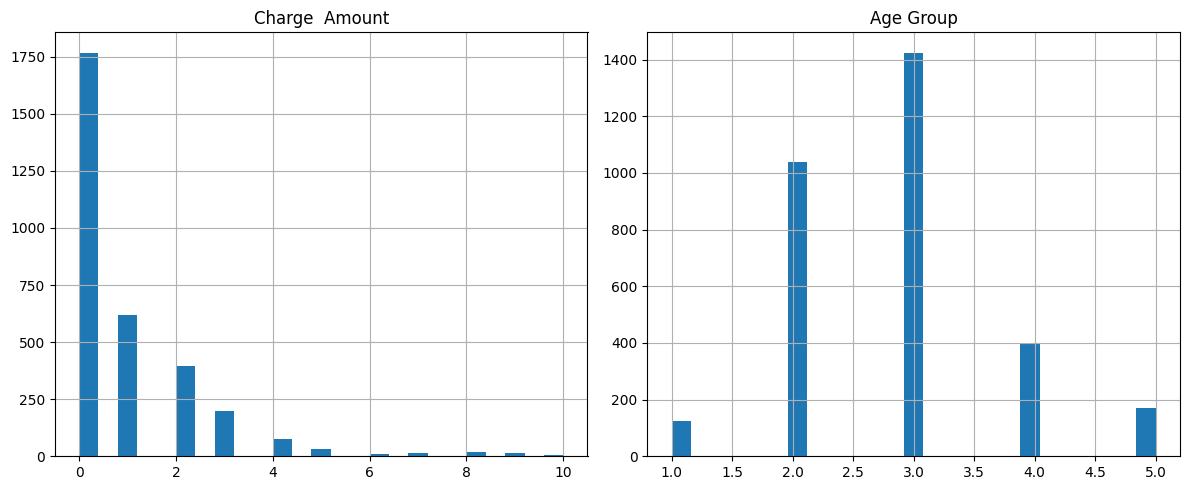

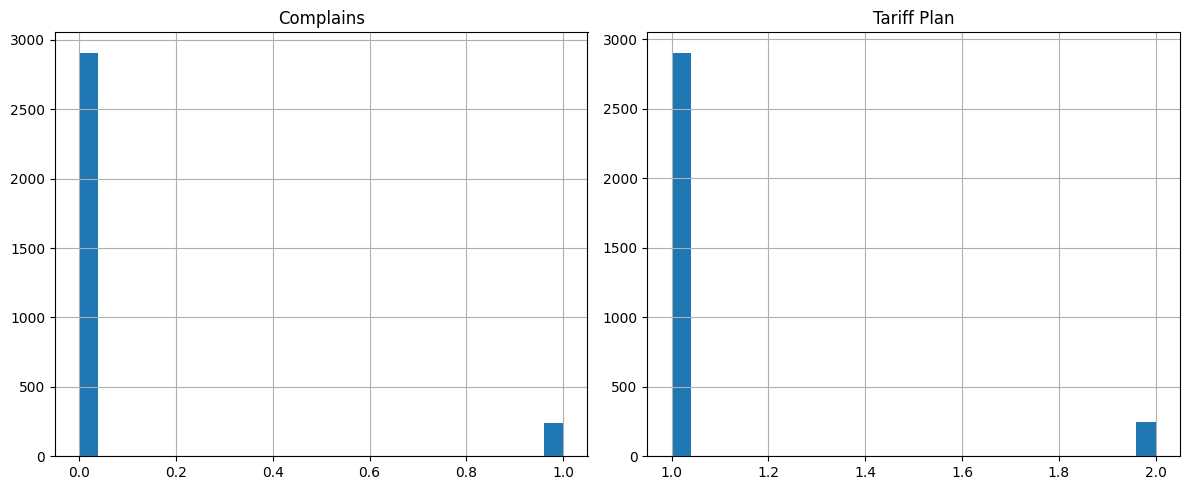

In [97]:
df[[x for x in df.keys() if x in ordinal_keys]].hist(bins=25, figsize= (12,5))
plt.tight_layout()
df[[x for x in df.keys() if x in binary_keys]].hist(bins=25, figsize= (12,5))
plt.tight_layout()

In [40]:
RF_HP_params = dict(
    min_samples_leaf = [1, 2, 3],
    n_estimators = [100, 250, 500, 1000],
    max_depth = [None, 10, 20, 30],
)

HGBC_HP_params = dict(
    min_samples_leaf = [10, 20, 30, 40],
    learning_rate = [1e-2, 1e-1, 2.5e-1],
    l2_regularization = [0, 1e-2, 1e-1, 2.5e-1],
    max_iter = [50, 100, 150, 250]
)

RF_model = RandomForestClassifier(class_weight = 'balanced_subsample')
HGBC_model = HistGradientBoostingClassifier(class_weight = 'balanced')

RF_grid_search = GridSearchCV(estimator = RF_model, param_grid= RF_HP_params, cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1), n_jobs =-1, scoring = 'f1', verbose = 10)
HGBC_grid_search = GridSearchCV(estimator = HGBC_model, param_grid= HGBC_HP_params, cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1), n_jobs=-1, scoring = 'f1', verbose =10)


In [41]:
RF_grid_search.fit(df[predictor_keys], df[label_key].values.ravel())

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=None),
             estimator=RandomForestClassifier(class_weight='balanced_subsample'),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [100, 250, 500, 1000]},
             scoring='f1', verbose=10)

In [42]:
doge = RF_grid_search.cv_results_

In [43]:
RF_grid_search.cv_results_

{'mean_fit_time': array([0.73047915, 1.67649183, 3.37811499, 6.90751338, 0.65379353,
        1.50093498, 3.16783838, 6.31393952, 0.62924514, 1.52688012,
        2.9983098 , 7.19675503, 0.57310715, 1.69177365, 3.68577399,
        6.94893479, 0.74793248, 2.0794558 , 4.24255571, 7.03613257,
        0.73569388, 1.86620045, 3.55529752, 7.89657917, 0.82046208,
        2.26513519, 4.34528055, 9.87696066, 0.84658747, 2.24820752,
        4.61980009, 9.24703469, 1.06875658, 2.20264158, 4.16267767,
        8.44230042, 0.86164093, 2.18147306, 4.52694378, 9.17673011,
        0.83512092, 2.19252715, 4.47863574, 8.59449401, 0.78773232,
        2.0541121 , 4.2061069 , 6.00132403]),
 'std_fit_time': array([0.07887325, 0.10838066, 0.31805067, 0.61431647, 0.04082574,
        0.07048051, 0.19770134, 0.28636406, 0.01072177, 0.10347636,
        0.13150899, 0.55774573, 0.05842851, 0.31007623, 0.55354422,
        0.46998228, 0.12933394, 0.41682373, 0.40995562, 0.63820786,
        0.11658234, 0.22985424, 0.093

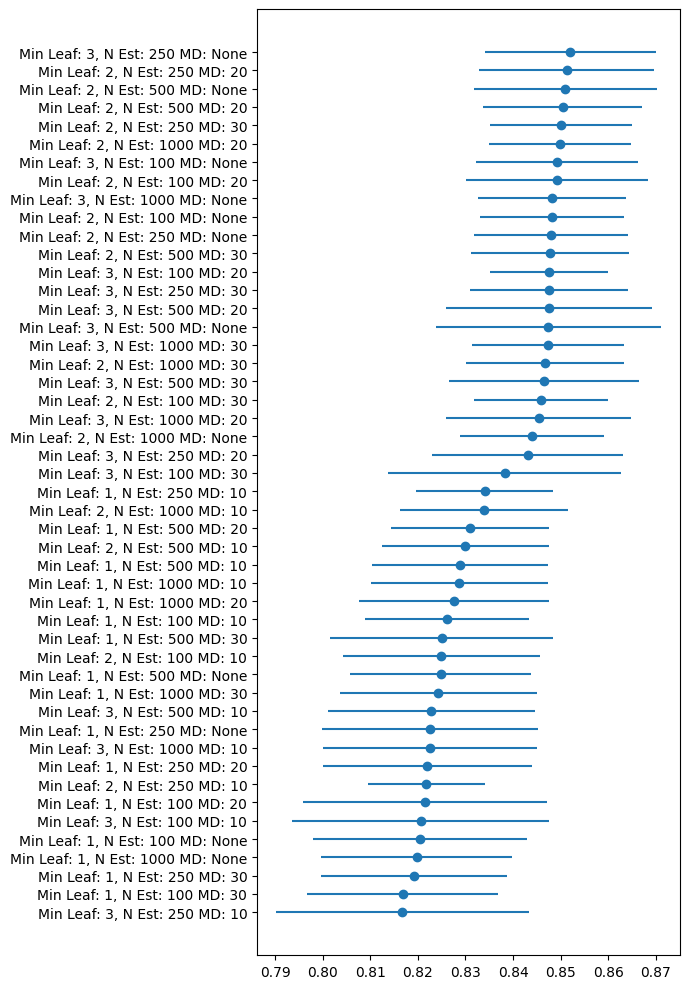

In [44]:
error_plotter = pd.DataFrame(RF_grid_search.cv_results_)
error_plotter['params'] = error_plotter['params'].apply(lambda x: f"Min Leaf: {x['min_samples_leaf']}, N Est: {x['n_estimators']} MD: {x['max_depth']}")
model_perf_sort_inds = np.argsort(error_plotter['mean_test_score'].values)

plt.subplots(figsize = (7,10))
plt.errorbar(error_plotter['mean_test_score'].values[model_perf_sort_inds], 
             range(len(error_plotter['params'])),
             xerr = error_plotter['std_test_score'].values[model_perf_sort_inds], fmt='o')

plt.yticks(range(len(error_plotter['params'])), error_plotter['params'].values[model_perf_sort_inds]);
plt.tight_layout()


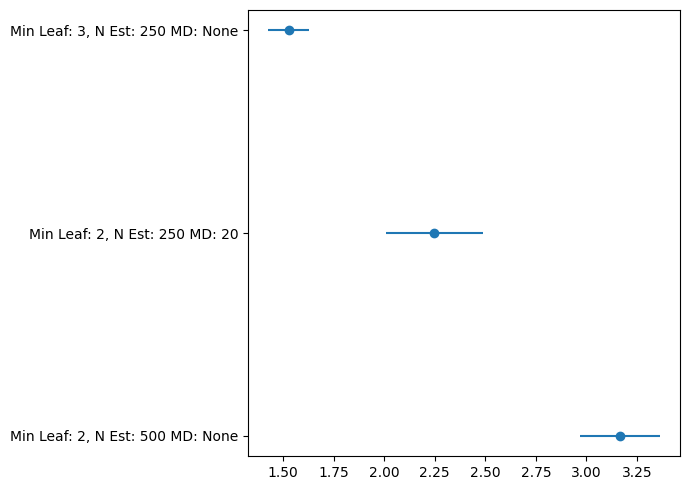

In [45]:
model_perf_sort_inds = np.argsort(error_plotter['mean_test_score'].values)[-3:]

plt.subplots(figsize = (7,5))
plt.errorbar(error_plotter['mean_fit_time'].values[model_perf_sort_inds], 
             range(len(model_perf_sort_inds)),
             xerr = error_plotter['std_fit_time'].values[model_perf_sort_inds], fmt='o')

plt.yticks(range(len(model_perf_sort_inds)), error_plotter['params'].values[model_perf_sort_inds]);
plt.tight_layout()

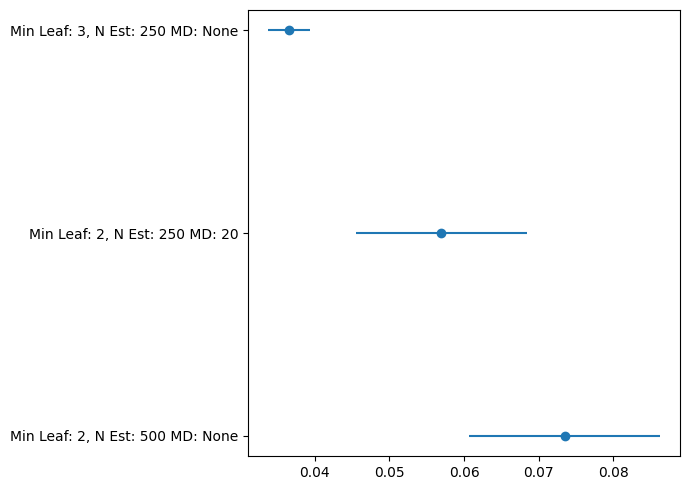

In [46]:
model_perf_sort_inds = np.argsort(error_plotter['mean_test_score'].values)[-3:]

plt.subplots(figsize = (7,5))
plt.errorbar(error_plotter['mean_score_time'].values[model_perf_sort_inds], 
             range(len(model_perf_sort_inds)),
             xerr = error_plotter['std_score_time'].values[model_perf_sort_inds], fmt='o')

plt.yticks(range(len(model_perf_sort_inds)), error_plotter['params'].values[model_perf_sort_inds]);
plt.tight_layout()

In [47]:
HGBC_grid_search.fit(df[predictor_keys], df[label_key].values.ravel())

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=None),
             estimator=HistGradientBoostingClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'l2_regularization': [0, 0.01, 0.1, 0.25],
                         'learning_rate': [0.01, 0.1, 0.25],
                         'max_iter': [50, 100, 150, 250],
                         'min_samples_leaf': [10, 20, 30, 40]},
             scoring='f1', verbose=10)

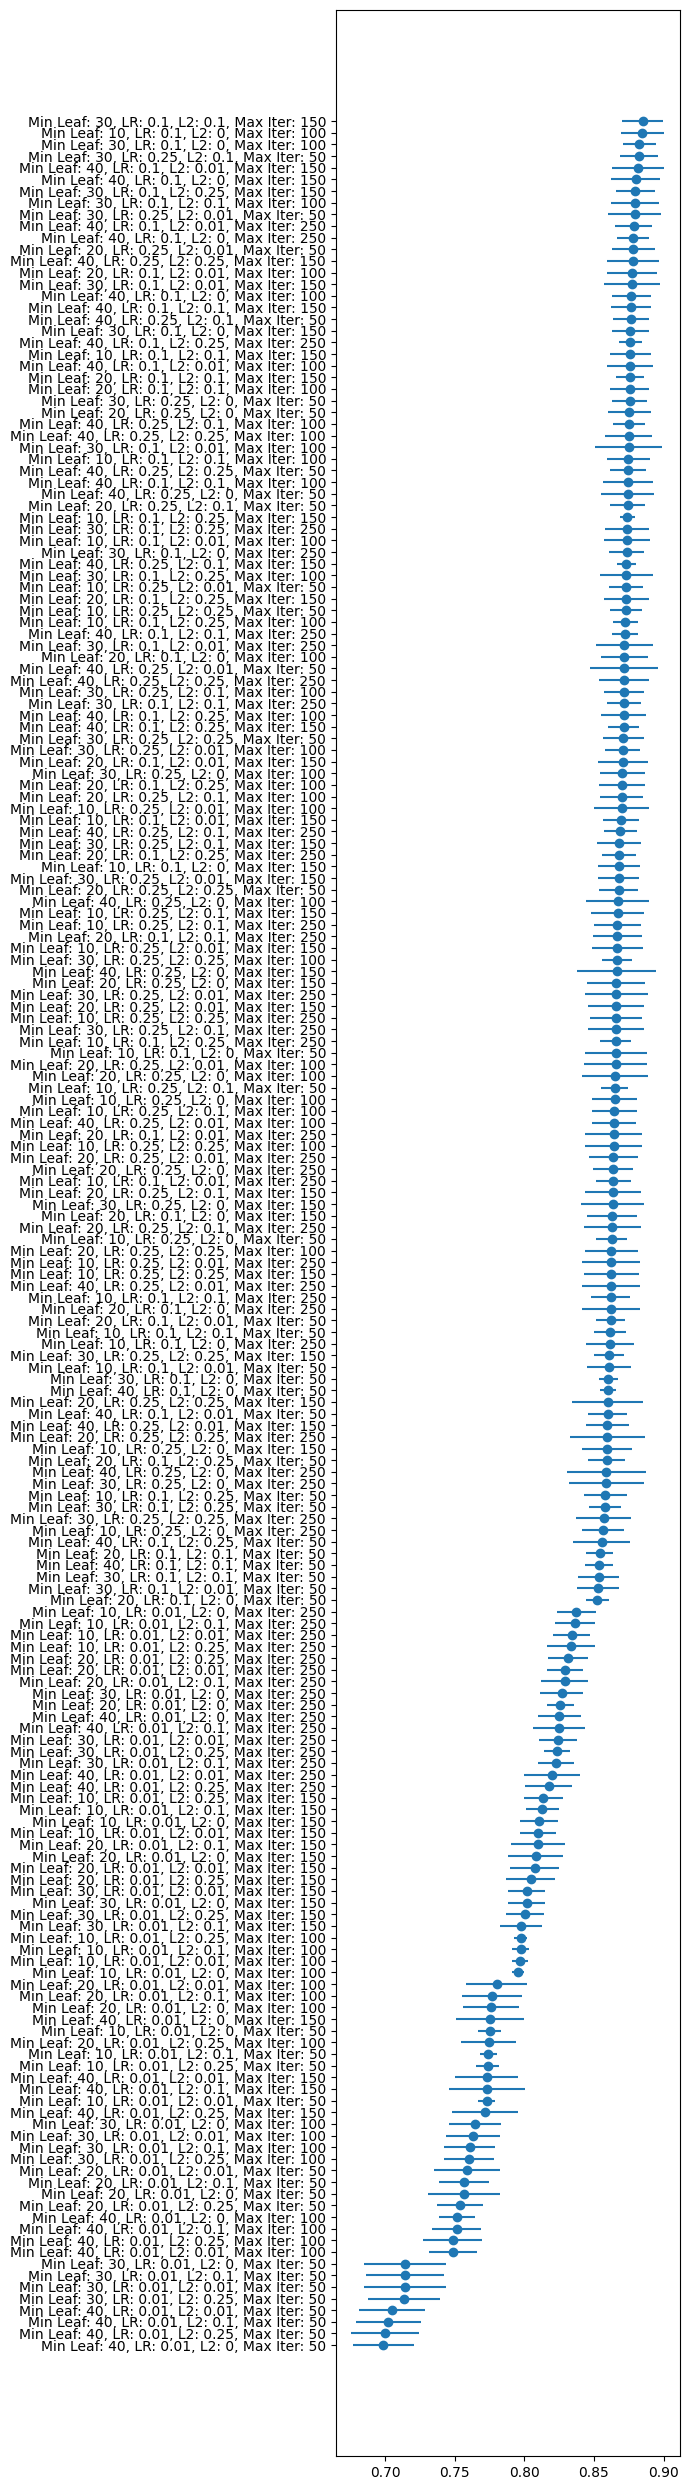

In [48]:
error_plotter = pd.DataFrame(HGBC_grid_search.cv_results_)
error_plotter['params'] = error_plotter['params'].apply(lambda x: f"Min Leaf: {x['min_samples_leaf']}, LR: {x['learning_rate']}, L2: {x['l2_regularization']}, Max Iter: {x['max_iter']}")

model_perf_sort_inds = np.argsort(error_plotter['mean_test_score'].values)

plt.subplots(figsize = (7,25))
plt.errorbar(error_plotter['mean_test_score'].values[model_perf_sort_inds], 
             range(len(error_plotter['params'])),
             xerr = error_plotter['std_test_score'].values[model_perf_sort_inds], fmt='o')

plt.yticks(range(len(error_plotter['params'])), error_plotter['params'].values[model_perf_sort_inds]);
plt.tight_layout()

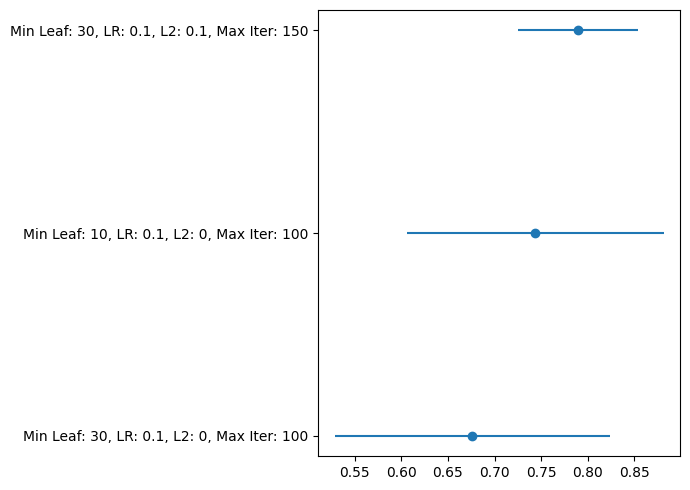

In [49]:
model_perf_sort_inds = np.argsort(error_plotter['mean_test_score'].values)[-3:]

plt.subplots(figsize = (7,5))
plt.errorbar(error_plotter['mean_fit_time'].values[model_perf_sort_inds], 
             range(len(model_perf_sort_inds)),
             xerr = error_plotter['std_fit_time'].values[model_perf_sort_inds], fmt='o')

plt.yticks(range(len(model_perf_sort_inds)), error_plotter['params'].values[model_perf_sort_inds]);
plt.tight_layout()

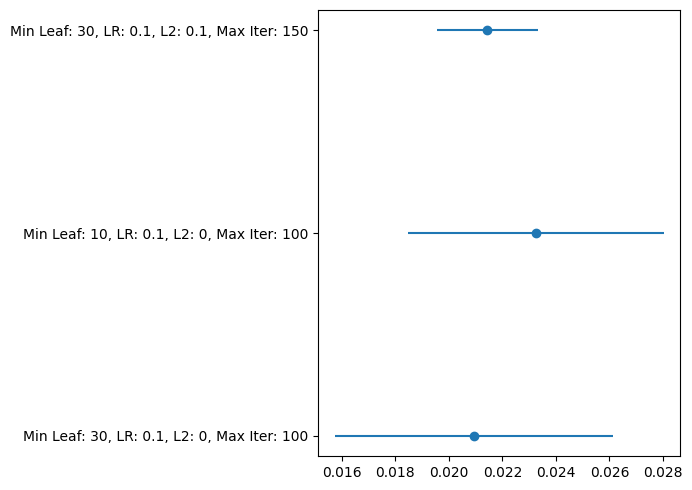

In [50]:
model_perf_sort_inds = np.argsort(error_plotter['mean_test_score'].values)[-3:]

plt.subplots(figsize = (7,5))
plt.errorbar(error_plotter['mean_score_time'].values[model_perf_sort_inds], 
             range(len(model_perf_sort_inds)),
             xerr = error_plotter['std_score_time'].values[model_perf_sort_inds], fmt='o')

plt.yticks(range(len(model_perf_sort_inds)), error_plotter['params'].values[model_perf_sort_inds]);
plt.tight_layout()

In [51]:
RF_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

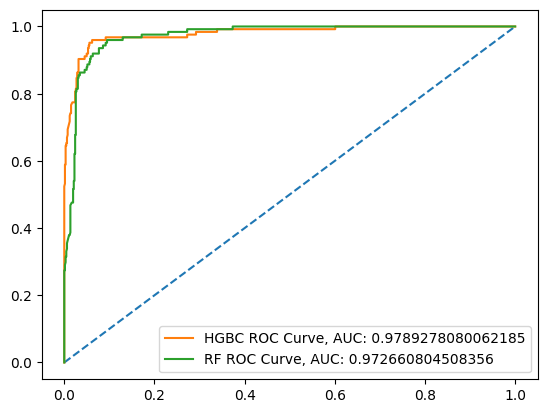

In [52]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(df[predictor_keys], df[label_key].values.ravel(), stratify=df[label_key].values.ravel())
best_RF_model = RF_grid_search.best_estimator_.fit(Xtrain, Ytrain)
best_HGBC_model = HGBC_grid_search.best_estimator_.fit(Xtrain, Ytrain)

plt.figure()
plt.plot(np.linspace(0,1), np.linspace(0,1), linestyle = 'dashed')
for model, name in zip([best_HGBC_model, best_RF_model],['HGBC', 'RF']):
    fpr, tpr, thresholds = roc_curve(Ytest, model.predict_proba(Xtest)[:,1])
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = f'{name} ROC Curve, AUC: {auc}')

plt.legend()
plt.show()

In [53]:
#let's move forward with the HGBC, first to make sure we get a nice stable threshold
ideal_thres_stack = []
for i in range(50):
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(df[predictor_keys], df[label_key].values.ravel(), test_size=0.3, stratify=df[label_key].values.ravel())
    best_HGBC_model.fit(Xtrain, Ytrain)
    fpr, tpr, thresholds = roc_curve(Ytest, best_HGBC_model.predict_proba(Xtest)[:,1])

    gmeans = np.sqrt(tpr*(1-fpr))
    ideal_thres_stack.append(np.argmax(gmeans))
ideal_thres = np.round(np.mean(ideal_thres_stack))

In [54]:
ideal_thres = np.round(np.mean(ideal_thres_stack))

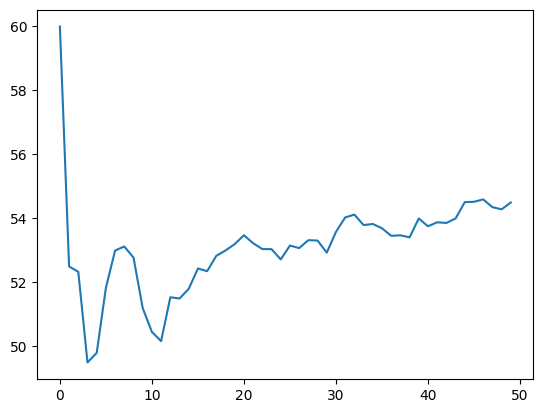

In [55]:
plt.plot(np.cumsum(ideal_thres_stack)/(np.arange(len(ideal_thres_stack))+1))

In [56]:
class reThresh_HGBC:
    def __init__(self, model, thresh = 0.5) -> None:
        self.model = model
        self.thresh = thresh
    def predict(self, X) -> int:
        return (self.model.predict_proba(X)[:,1]*100>=self.thresh).astype(int)
    def fit(self, X, Y) -> None:
        self.model = self.model.fit(X, Y)
    def predict_proba(self, X):
        return self.model.predict_proba(X)

In [57]:
final_model = reThresh_HGBC(best_HGBC_model, ideal_thres)
perform = {'Tuned HGBC': [], 'Untuned HGBC':[]}
for model, model_name in zip([final_model, best_HGBC_model], ['Tuned HGBC', 'Untuned HGBC']):
    for i in range(50):
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(df[predictor_keys], df[label_key].values.ravel(), test_size=0.3, stratify=df[label_key].values.ravel())
        model.fit(Xtrain, Ytrain)
        perform[model_name].append(metrics.f1_score(Ytest, model.predict(Xtest)))


<Axes: >

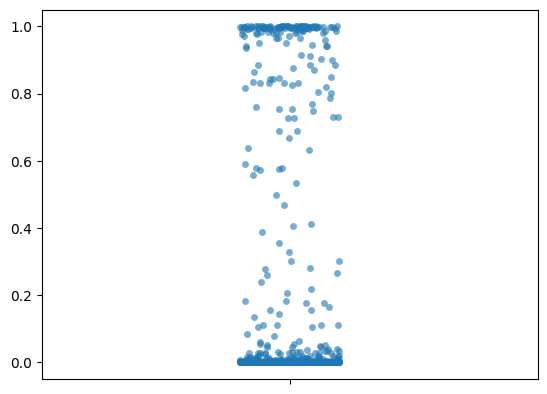

In [58]:
best_HGBC_model.fit(Xtrain, Ytrain)
proba = best_HGBC_model.predict_proba(Xtest)[:,1]
sns.stripplot(y=proba, alpha=0.6)

In [59]:
for model_name, f1s in perform.items():
    print(f'{model_name} has a mean f1 of {np.mean(f1s)} with a std of {np.std(f1s)}')

Tuned HGBC has a mean f1 of 0.8651024849560334 with a std of 0.017264108600066858
Untuned HGBC has a mean f1 of 0.871039396288133 with a std of 0.02021913474561472


In [60]:
from sklearn.calibration import calibration_curve, CalibrationDisplay
Xtrain, Xtest, Ytrain, Ytest = train_test_split(df[predictor_keys], df[label_key].values.ravel(), test_size=0.3, stratify=df[label_key].values.ravel())
best_HGBC_model.fit(Xtrain, Ytrain)
final_model.fit(Xtrain, Ytrain)



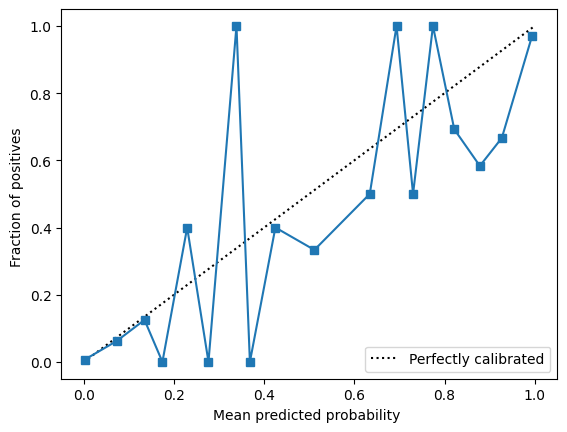

In [61]:
y_prob = best_HGBC_model.predict_proba(Xtest)[:, 1]
prob_true, prob_pred = calibration_curve(Ytest, y_prob, n_bins=20)
calD = CalibrationDisplay(prob_true, prob_pred, y_prob)
calD.plot()

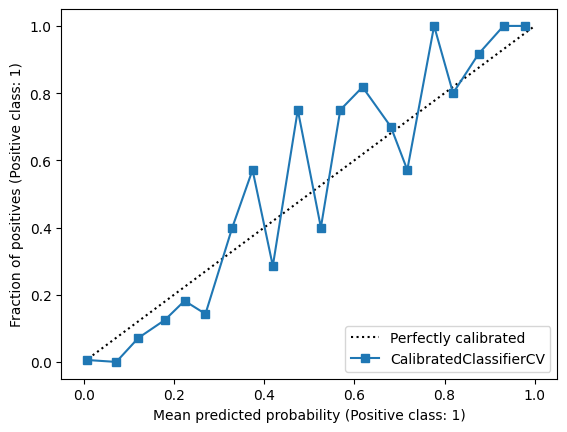

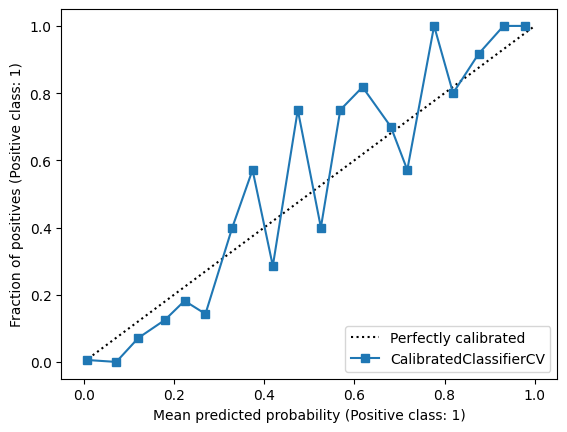

In [62]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_HGBC = CalibratedClassifierCV(best_HGBC_model)
calibrated_HGBC.fit(Xtrain, Ytrain)
calD = CalibrationDisplay.from_estimator(calibrated_HGBC, Xtest, Ytest, n_bins=20)
calD.plot()

In [63]:

perform = {'Calibrated HGBC': [], 'HGBC':[]}
for model, model_name in zip([calibrated_HGBC, best_HGBC_model], ['Calibrated HGBC', 'HGBC']):
    for i in range(50):
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(df[predictor_keys], df[label_key].values.ravel(), test_size=0.3, stratify=df[label_key].values.ravel())
        model.fit(Xtrain, Ytrain)
        perform[model_name].append(metrics.f1_score(Ytest, model.predict(Xtest)))


In [64]:
for model_name, f1s in perform.items():
    print(f'{model_name} has a mean f1 of {np.mean(f1s)} with a std of {np.std(f1s)}')

Calibrated HGBC has a mean f1 of 0.8562125840460473 with a std of 0.017878984997965957
HGBC has a mean f1 of 0.8641713930339351 with a std of 0.02117152560968184


<Axes: >

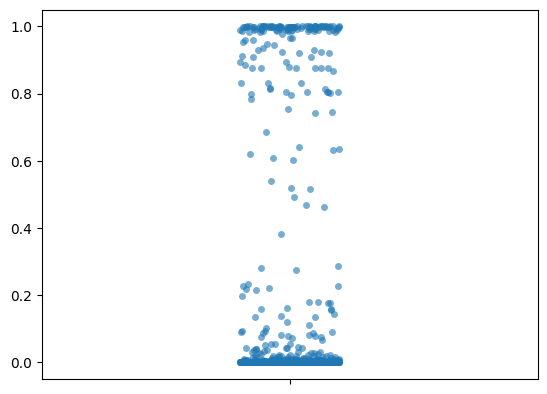

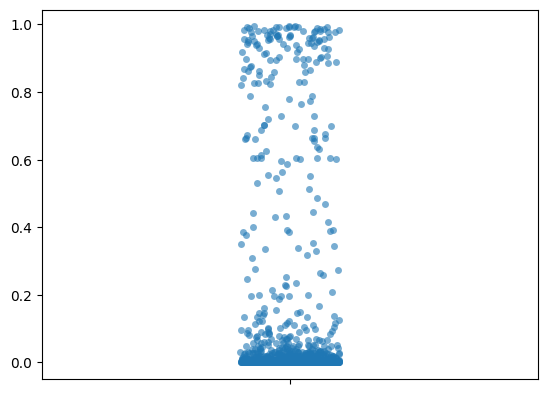

In [65]:
best_HGBC_model.fit(Xtrain, Ytrain)
proba = best_HGBC_model.predict_proba(Xtest)[:,1]
sns.stripplot(y=proba, alpha=0.6)
plt.figure()
calibrated_HGBC.fit(Xtrain, Ytrain)
proba = calibrated_HGBC.predict_proba(Xtest)[:,1]
sns.stripplot(y=proba, alpha=0.6)

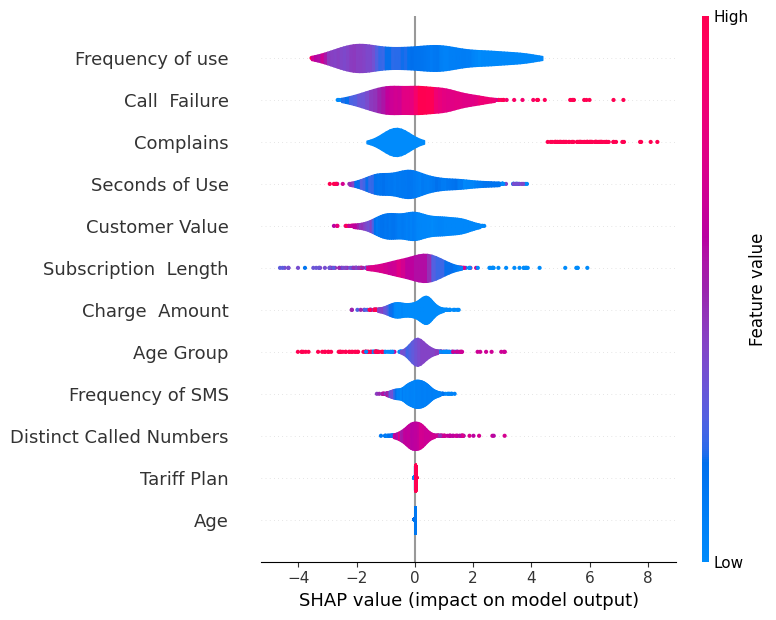

In [66]:
explainer = shap.TreeExplainer(best_HGBC_model)
shap_values = explainer.shap_values(Xtest)
shap.summary_plot(shap_values, Xtest, plot_type="violin")

In [67]:
mean_shap = np.mean(shap_values, axis =0)